In [1]:
# =========================================
# 1) Cargar datos y objetivo (Atraso escolar)
# =========================================
import os, json, warnings, platform, datetime
import numpy as np
import pandas as pd
import joblib
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_FILE = "student-mat.csv"      # tu archivo
TARGET    = "target_atraso"        # nombre de la nueva columna objetivo

assert os.path.exists(DATA_FILE), f"No se encuentra {DATA_FILE}"

# IMPORTANTE: este dataset viene con separador ';'
df = pd.read_csv(DATA_FILE, sep=";")

# Definir atraso: 1 = ATRASO, 0 = NO_ATRASO
df[TARGET] = ((df["G3"] < 10) | (df["failures"] >= 1)).astype(int)

# y = objetivo; X = features sin G1, G2, G3 para evitar fuga de info
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET, "G1", "G2", "G3"])

print("Shape X:", X.shape)
print("Prevalencia ATRASO (1):", (y == 1).mean())


Shape X: (395, 30)
Prevalencia ATRASO (1): 0.40759493670886077


In [6]:
# =========================================
# 2) Split temprano (80/20)
# =========================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")


Train: (316, 30) | Test: (79, 30)


In [8]:
# =========================================
# 3) Preprocesamiento (en pipeline)
# =========================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

cat_features = X_train.select_dtypes(include=["object","category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["number","bool"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ]
)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)

def build_pipe(model):
    return ImbPipeline([("prep", preprocessor), ("smote", smote), ("model", model)])


In [10]:
# =========================================
# 4) Modelos candidatos – Atraso escolar por hábitos
# (solo modelos de scikit-learn, sin XGBoost/LGBM/CatBoost)
# =========================================
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

candidates = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("LDA", LinearDiscriminantAnalysis()),
    ("KNN", KNeighborsClassifier()),
    ("GNB", GaussianNB()),
    ("DTS", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ("NNM", MLPClassifier(
        hidden_layer_sizes=(64,),
        max_iter=600,
        random_state=RANDOM_STATE
    )),
]


In [11]:
# =========================================
# 5) Entrenar Baseline con CV (sin tuning)
#    Clasificación: ATRASO (1) vs NO_ATRASO (0)
# =========================================
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Como la clase positiva es ATRASO = 1, roc_auc tiene sentido
scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
    "roc_auc":  "roc_auc"
}

baseline_rows = []
for name, model in candidates:
    pipe = build_pipe(model)
    scores = cross_validate(
        pipe,
        X_train,
        y_train,          # y_train = target_atraso (1=ATRASO, 0=NO_ATRASO)
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    baseline_rows.append({
        "model":   name,
        "acc_mean": scores["test_accuracy"].mean(),
        "acc_std":  scores["test_accuracy"].std(),
        "f1_mean":  scores["test_f1_macro"].mean(),
        "f1_std":   scores["test_f1_macro"].std(),
        "auc_mean": scores["test_roc_auc"].mean(),
    })
    print(f"{name:>4} | ACC {scores['test_accuracy'].mean():.3f} "
          f"| F1 {scores['test_f1_macro'].mean():.3f} "
          f"| AUC {scores['test_roc_auc'].mean():.3f}")

baseline_df = pd.DataFrame(baseline_rows).sort_values("f1_mean", ascending=False)
display(baseline_df)

baseline_best_name  = baseline_df.iloc[0]["model"]
baseline_best_model = dict(candidates)[baseline_best_name]
print(f">>> Baseline ganador (atraso escolar): {baseline_best_name}")


 LRN | ACC 0.743 | F1 0.731 | AUC 0.824
 LDA | ACC 0.734 | F1 0.717 | AUC 0.793
 KNN | ACC 0.623 | F1 0.622 | AUC 0.724
 GNB | ACC 0.810 | F1 0.783 | AUC 0.827
 DTS | ACC 0.693 | F1 0.685 | AUC 0.686
 RFS | ACC 0.794 | F1 0.773 | AUC 0.829
 NNM | ACC 0.744 | F1 0.730 | AUC 0.811


,model,acc_mean,acc_std,f1_mean,f1_std,auc_mean
3,GNB,0.810069,0.022856,0.783193,0.029448,0.826757
5,RFS,0.794097,0.042080,0.773087,0.040819,0.828950
0,LRN,0.743452,0.039141,0.731158,0.036921,0.824227
6,NNM,0.743552,0.022223,0.730209,0.020737,0.810887
1,LDA,0.733978,0.051374,0.717385,0.054154,0.793146
4,DTS,0.693056,0.057188,0.684506,0.055713,0.686420
2,KNN,0.623165,0.047999,0.621619,0.048529,0.724400


>>> Baseline ganador (atraso escolar): GNB


In [12]:
# =========================================
# 6) Tuning con CV y elección del ganador (rápido)
#    Tema: Atraso escolar (1) vs No atraso (0)
# =========================================
import tempfile, shutil
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
try:
    from scipy.stats import loguniform
except Exception:
    from sklearn.utils.fixes import loguniform  # fallback

# CV "ligera" y "pesada" (aunque solo tenemos modelos ligeros/medios)
cv_light = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_heavy = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Espacios de hiperparámetros SOLO para LRN y RFS
param_spaces = {
    "LRN": {
        "model__C": loguniform(1e-2, 1e1),
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs", "liblinear"],
        "model__class_weight": [None, "balanced"],
    },
    "RFS": {
        "model__n_estimators": randint(200, 500),
        "model__max_depth": randint(4, 14),
        "model__min_samples_split": randint(2, 16),
        "model__min_samples_leaf": randint(1, 8),
        "model__max_features": ["sqrt", "log2", None],
        "model__bootstrap": [True, False],
    },
}

# Modelos a tunear (sin XGB, LGB, CAT para evitar problemas de instalación)
to_tune = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1)),
]

# Métrica principal para refit: F1_macro (importante por el desbalance ATRASO / NO_ATRASO)
refit_metric = "f1_macro"
scoring_opt = {
    "f1_macro": "f1_macro",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
}

best_models = []
cache_dir = tempfile.mkdtemp(prefix="skcache_")

try:
    for name, base_model in to_tune:
        print(f"\n>>> Tuning de modelo: {name}")
        pipe = build_pipe(base_model)
        # Usar caché para acelerar
        try:
            pipe.set_params(memory=cache_dir)
        except Exception:
            pass

        # Si quisieras tratar alguno como "pesado", lo marcas aquí
        heavy = (name == "RFS")  # por ejemplo, RF un poco más pesado

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_spaces[name],
            n_iter=(15 if heavy else 12),
            cv=(cv_heavy if heavy else cv_light),
            scoring=scoring_opt,
            refit=refit_metric,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbose=1,
            return_train_score=False,
            error_score=np.nan,
        )

        search.fit(X_train, y_train)  # y_train = target_atraso

        best_models.append(
            (name, search.best_estimator_, search.best_score_, search.best_params_)
        )
        print(f"  >> Mejor F1_macro CV {name}: {search.best_score_:.4f}")
        print(f"  >> Mejores params {name}: {search.best_params_}")

    # Ordenar por mejor F1_macro
    best_models.sort(
        key=lambda x: (x[2] if pd.notna(x[2]) else -1), reverse=True
    )
    best_name, final_pipe_opt, best_cv_f1, best_params = best_models[0]
    print("\n=========================================")
    print(f">>> GANADOR OPTIMIZADO: {best_name} (F1 CV={best_cv_f1:.4f})")
    print(">>> Mejores hiperparámetros:", best_params)
    print("=========================================")

finally:
    # limpiar caché
    shutil.rmtree(cache_dir, ignore_errors=True)



>>> Tuning de modelo: LRN
Fitting 5 folds for each of 12 candidates, totalling 60 fits
  >> Mejor F1_macro CV LRN: 0.7606
  >> Mejores params LRN: {'model__C': 0.035113563139704075, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

>>> Tuning de modelo: RFS
Fitting 3 folds for each of 15 candidates, totalling 45 fits
  >> Mejor F1_macro CV RFS: 0.7741
  >> Mejores params RFS: {'model__bootstrap': False, 'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 441}

>>> GANADOR OPTIMIZADO: RFS (F1 CV=0.7741)
>>> Mejores hiperparámetros: {'model__bootstrap': False, 'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 441}


In [13]:
# =========================================
# 7) Comparación justa (solo CV) - baseline vs ganador
#    Tema: Atraso escolar (1) vs No atraso (0)
# =========================================
from sklearn.model_selection import StratifiedKFold, cross_validate

same_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# pipeline con el mejor modelo baseline (sin tuning)
pipe_baseline_best = build_pipe(baseline_best_model)

# pipeline ya optimizado (viene de la celda 6: final_pipe_opt)
pipe_tuned_best    = final_pipe_opt

def cv_summary(pipe, name):
    scores = cross_validate(
        pipe,
        X_train,
        y_train,   # y_train = target_atraso (1=ATRASO, 0=NO_ATRASO)
        cv=same_cv,
        scoring={
            "f1_macro": "f1_macro",
            "roc_auc":  "roc_auc",
            "accuracy": "accuracy",
        },
        n_jobs=-1
    )
    print(
        f"{name}: "
        f"F1 {scores['test_f1_macro'].mean():.4f}±{scores['test_f1_macro'].std():.4f} | "
        f"AUC {scores['test_roc_auc'].mean():.4f} | "
        f"ACC {scores['test_accuracy'].mean():.4f}"
    )
    return scores["test_f1_macro"].mean()

f1_base = cv_summary(pipe_baseline_best, f"Baseline({baseline_best_name})")
f1_tune = cv_summary(pipe_tuned_best,   f"Tuned({best_name})")

# Regla: si la mejora de F1_macro < 0.005, elegimos el modelo más simple (baseline).
if (f1_tune - f1_base) >= 0.005:
    winner_name, winner_pipe = best_name, pipe_tuned_best
else:
    winner_name, winner_pipe = baseline_best_name, pipe_baseline_best

print(f">>> Modelo seleccionado para TEST (atraso escolar): {winner_name}")


Baseline(GNB): F1 0.7826±0.0449 | AUC 0.8366 | ACC 0.8102
Tuned(RFS): F1 0.7757±0.0417 | AUC 0.8303 | ACC 0.7974
>>> Modelo seleccionado para TEST (atraso escolar): GNB


In [14]:
# =========================================
# 8) Política de decisión (mínima)
#    Tema: Atraso escolar (1) vs No atraso (0)
# =========================================
# Por ahora, usamos el umbral clásico de 0.50:
#   proba(ATRASO) >= 0.50  --> predicción = ATRASO (1)
#   proba(ATRASO) <  0.50  --> predicción = NO_ATRASO (0)
#
# Más adelante puedes optimizar este umbral con CV para:
#   - maximizar F1, o
#   - lograr cierta Recall para ATRASO (no perder muchos casos en riesgo), etc.

BEST_THR = 0.50
print(f"Umbral de decisión (provisorio) para ATRASO escolar: {BEST_THR}")


Umbral de decisión (provisorio) para ATRASO escolar: 0.5


In [15]:
# =========================================
# 9) Evaluación final en TEST
#    Tema: Atraso escolar (1) vs No atraso (0)
# =========================================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)

# winner_pipe viene de la celda 7 (modelo seleccionado)
winner_pipe.fit(X_train, y_train)

# Probabilidad de clase positiva = ATRASO (1)
proba_test = winner_pipe.predict_proba(X_test)[:, 1]

# Predicción binaria usando el umbral BEST_THR
y_pred = (proba_test >= BEST_THR).astype(int)

print("\n== Reporte en TEST – Atraso escolar ==")
print(classification_report(y_test, y_pred, digits=4))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, proba_test))
print("PR-AUC :", average_precision_score(y_test, proba_test))



== Reporte en TEST – Atraso escolar ==
              precision    recall  f1-score   support

           0     0.7925    0.8936    0.8400        47
           1     0.8077    0.6562    0.7241        32

    accuracy                         0.7975        79
   macro avg     0.8001    0.7749    0.7821        79
weighted avg     0.7986    0.7975    0.7931        79

Matriz de confusión:
 [[42  5]
 [11 21]]
ROC-AUC: 0.8124999999999999
PR-AUC : 0.7532296466243336


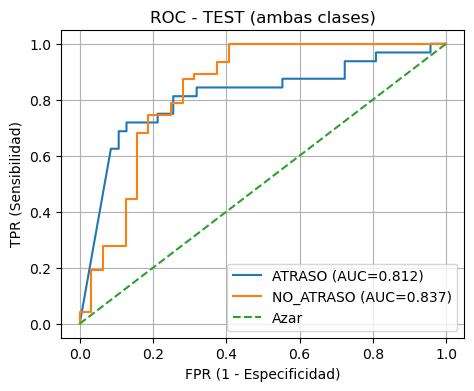

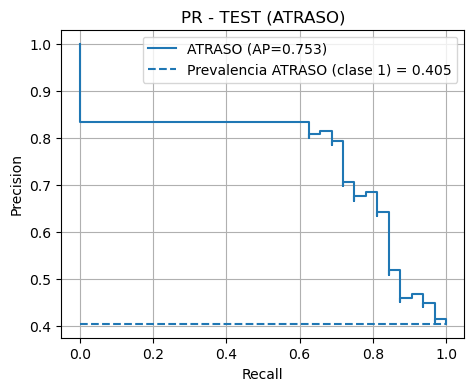

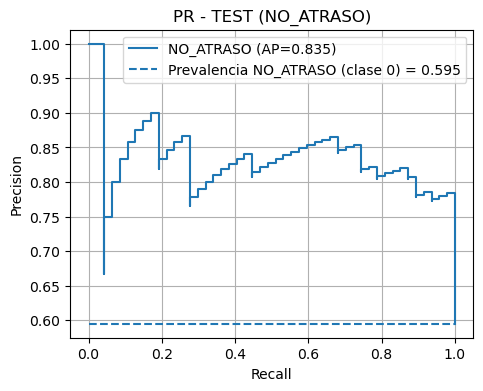

In [16]:
# === Curvas ROC y PR para ambas clases (ATRASO=1 y NO_ATRASO=0) ===
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt

# Probabilidades por clase
proba  = winner_pipe.predict_proba(X_test)
proba1 = proba[:, 1]  # P(ATRASO=1 | x)
proba0 = proba[:, 0]  # P(NO_ATRASO=0 | x)

y_true = np.asarray(y_test)

# -------- ROC --------
# Clase 1 (ATRASO)
fpr1, tpr1, _ = roc_curve(y_true, proba1)
roc_auc1 = auc(fpr1, tpr1)

# Clase 0 (NO_ATRASO): hacemos positiva a la clase 0
y_true0 = 1 - y_true
fpr0, tpr0, _ = roc_curve(y_true0, proba0)
roc_auc0 = auc(fpr0, tpr0)

plt.figure(figsize=(5.2, 4))
plt.plot(fpr1, tpr1, label=f"ATRASO (AUC={roc_auc1:.3f})")
plt.plot(fpr0, tpr0, label=f"NO_ATRASO (AUC={roc_auc0:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Azar")
plt.xlabel("FPR (1 - Especificidad)")
plt.ylabel("TPR (Sensibilidad)")
plt.title("ROC - TEST (ambas clases)")
plt.legend()
plt.grid(True)
plt.show()

# -------- PR (Precision-Recall) --------
# Clase 1 (ATRASO)
prec1, rec1, _ = precision_recall_curve(y_true, proba1)
ap1 = average_precision_score(y_true, proba1)
prev1 = y_true.mean()  # prevalencia de ATRASO (clase 1)

plt.figure(figsize=(5.2, 4))
plt.step(rec1, prec1, where="post", label=f"ATRASO (AP={ap1:.3f})")
plt.hlines(prev1, 0, 1, linestyles="--",
           label=f"Prevalencia ATRASO (clase 1) = {prev1:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR - TEST (ATRASO)")
plt.legend()
plt.grid(True)
plt.show()

# Clase 0 (NO_ATRASO) como positiva
prec0, rec0, _ = precision_recall_curve(y_true0, proba0)
ap0 = average_precision_score(y_true0, proba0)
prev0 = y_true0.mean()  # = 1 - prev1

plt.figure(figsize=(5.2, 4))
plt.step(rec0, prec0, where="post", label=f"NO_ATRASO (AP={ap0:.3f})")
plt.hlines(prev0, 0, 1, linestyles="--",
           label=f"Prevalencia NO_ATRASO (clase 0) = {prev0:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR - TEST (NO_ATRASO)")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# =========================================
# 11) Exportar artefactos (mínimo)
#    Tema: Atraso escolar (1) vs No atraso (0)
# =========================================
import sklearn
import os, json

version_id = "v1"  # o datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
ART_DIR = os.path.join("artefactos", version_id)
os.makedirs(ART_DIR, exist_ok=True)

# -------- Pipeline ganador --------
pipe_path = os.path.join(ART_DIR, f"pipeline_{winner_name}.joblib")
joblib.dump(winner_pipe, pipe_path)

# -------- Esquema de entrada y mapa de etiquetas --------
schema = {c: str(X[c].dtype) for c in X.columns}
json.dump(
    schema,
    open(os.path.join(ART_DIR, "input_schema.json"), "w", encoding="utf-8"),
    ensure_ascii=False,
    indent=2,
)

# Mapa de etiquetas: 0 = NO_ATRASO, 1 = ATRASO
json.dump(
    {"NO_ATRASO": 0, "ATRASO": 1},
    open(os.path.join(ART_DIR, "label_map.json"), "w", encoding="utf-8"),
    ensure_ascii=False,
    indent=2,
)

# -------- Política de decisión (usa BEST_THR provisional) --------
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)

def pack_metrics(y_true, proba, thr):
    yp = (proba >= thr).astype(int)
    return {
        "f1": float(f1_score(y_true, yp)),
        "precision": float(precision_score(y_true, yp, zero_division=0)),
        "recall": float(recall_score(y_true, yp)),
        "roc_auc": float(roc_auc_score(y_true, proba)),
        "pr_auc": float(average_precision_score(y_true, proba)),
        "confusion_matrix": confusion_matrix(y_true, yp).tolist(),
    }

decision = {
    "winner": winner_name,
    "threshold": float(BEST_THR),
    "test_metrics": pack_metrics(y_test, proba_test, BEST_THR),
}

json.dump(
    decision,
    open(os.path.join(ART_DIR, "decision_policy.json"), "w", encoding="utf-8"),
    ensure_ascii=False,
    indent=2,
)

# -------- Model Card mínima --------
model_card_md = f"""# Model Card — {winner_name}
**Versión:** {version_id}  
**Sistema:** Python {platform.python_version()}, scikit-learn {sklearn.__version__}

## Datos
Archivo: `{DATA_FILE}`  
Shape: {X.shape}  
Objetivo: `{TARGET}` (ATRASO=1, NO_ATRASO=0)  
Prevalencia (ATRASO=1): {y.mean():.3f}

## Entrenamiento
Split 80/20 estratificado (random_state={RANDOM_STATE}).  
Preprocesamiento: StandardScaler (numéricas) + OneHotEncoder(ignore) (categóricas) + SMOTE(k=3).

## Modelo
Seleccionado para TEST: **{winner_name}**.  
Umbral de decisión: **{BEST_THR:.2f}** (provisional).  
Interpretación:  
- proba(ATRASO) >= {BEST_THR:.2f} → predicción ATRASO (1)  
- proba(ATRASO) <  {BEST_THR:.2f} → predicción NO_ATRASO (0)

## Métricas en TEST (clase positiva = ATRASO)
F1={decision['test_metrics']['f1']:.3f}, 
P={decision['test_metrics']['precision']:.3f}, 
R={decision['test_metrics']['recall']:.3f},  
ROC-AUC={decision['test_metrics']['roc_auc']:.3f}, 
PR-AUC={decision['test_metrics']['pr_auc']:.3f}.
"""
open(os.path.join(ART_DIR, "model_card.md"), "w", encoding="utf-8").write(model_card_md)

# -------- Ejemplos de entrada (5 primeros de TEST) --------
json.dump(
    X_test.iloc[:5].to_dict(orient="records"),
    open(os.path.join(ART_DIR, "sample_inputs.json"), "w", encoding="utf-8"),
    ensure_ascii=False,
    indent=2,
)

print(f"Artefactos guardados en: {ART_DIR}")


Artefactos guardados en: artefactos/v1


In [21]:
# Tomamos el esquema que ya construimos
INPUT_SCHEMA = schema

payload_one = {
    k: (0 if str(t).startswith(("int", "float")) else "")
    for k, t in INPUT_SCHEMA.items()
}
payload_one


{'school': '',
 'sex': '',
 'age': 0,
 'address': '',
 'famsize': '',
 'Pstatus': '',
 'Medu': 0,
 'Fedu': 0,
 'Mjob': '',
 'Fjob': '',
 'reason': '',
 'guardian': '',
 'traveltime': 0,
 'studytime': 0,
 'failures': 0,
 'schoolsup': '',
 'famsup': '',
 'paid': '',
 'activities': '',
 'nursery': '',
 'higher': '',
 'internet': '',
 'romantic': '',
 'famrel': 0,
 'freetime': 0,
 'goout': 0,
 'Dalc': 0,
 'Walc': 0,
 'health': 0,
 'absences': 0}

In [23]:
# =========================================
# Funciones de inferencia: predict_one y predict_batch
#    Tema: Atraso escolar (1) vs No atraso (0)
# =========================================
import pandas as pd

LABELS = {0: "NO_ATRASO", 1: "ATRASO"}

def predict_one(sample_dict):
    """
    Predice ATRASO/NO_ATRASO para un solo estudiante (dict).
    sample_dict: {"school": ..., "sex": ..., "age": ..., ...}
    """
    # DataFrame con un solo registro
    df = pd.DataFrame([sample_dict])

    # Reordenar columnas según las usadas en el entrenamiento (X.columns)
    # Si falta alguna columna, se crea con valor por defecto (0 o "")
    for col in X.columns:
        if col not in df.columns:
            # numéricas -> 0, categóricas -> ""
            if str(X[col].dtype).startswith(("int", "float")):
                df[col] = 0
            else:
                df[col] = ""
    df = df[X.columns]  # mismo orden de columnas que X

    # Probabilidad de ATRASO (clase 1)
    proba = winner_pipe.predict_proba(df)[:, 1][0]
    pred_int = int(proba >= BEST_THR)
    pred_label = LABELS[pred_int]

    return {
        "proba": float(proba),       # P(ATRASO | x)
        "pred_int": pred_int,        # 1 = ATRASO, 0 = NO_ATRASO
        "pred_label": pred_label,    # "ATRASO" / "NO_ATRASO"
        "threshold": float(BEST_THR)
    }

def predict_batch(list_of_dicts):
    """
    Predice para una lista de estudiantes (lista de dicts).
    Devuelve una lista de resultados (uno por estudiante).
    """
    df = pd.DataFrame(list_of_dicts)

    # Asegurar que están todas las columnas de X
    for col in X.columns:
        if col not in df.columns:
            if str(X[col].dtype).startswith(("int", "float")):
                df[col] = 0
            else:
                df[col] = ""
    df = df[X.columns]

    # Probabilidades de ATRASO
    proba = winner_pipe.predict_proba(df)[:, 1]
    preds_int = (proba >= BEST_THR).astype(int)

    results = []
    for p, z in zip(proba, preds_int):
        results.append({
            "proba": float(p),
            "pred_int": int(z),
            "pred_label": LABELS[int(z)],
            "threshold": float(BEST_THR)
        })
    return results


In [24]:
samples_json = """
[
  {
    "school": "GP",
    "sex": "F",
    "age": 17,
    "address": "U",
    "famsize": "GT3",
    "Pstatus": "T",
    "Medu": 3,
    "Fedu": 2,
    "Mjob": "services",
    "Fjob": "other",
    "reason": "course",
    "guardian": "mother",
    "traveltime": 1,
    "studytime": 2,
    "failures": 0,
    "schoolsup": "no",
    "famsup": "yes",
    "paid": "no",
    "activities": "yes",
    "nursery": "yes",
    "higher": "yes",
    "internet": "yes",
    "romantic": "no",
    "famrel": 4,
    "freetime": 3,
    "goout": 2,
    "Dalc": 1,
    "Walc": 1,
    "health": 4,
    "absences": 3
  },
  {
    "school": "MS",
    "sex": "M",
    "age": 18,
    "address": "R",
    "famsize": "LE3",
    "Pstatus": "A",
    "Medu": 1,
    "Fedu": 1,
    "Mjob": "other",
    "Fjob": "other",
    "reason": "home",
    "guardian": "father",
    "traveltime": 3,
    "studytime": 1,
    "failures": 2,
    "schoolsup": "yes",
    "famsup": "no",
    "paid": "no",
    "activities": "no",
    "nursery": "yes",
    "higher": "yes",
    "internet": "no",
    "romantic": "yes",
    "famrel": 2,
    "freetime": 4,
    "goout": 4,
    "Dalc": 3,
    "Walc": 4,
    "health": 3,
    "absences": 10
  },
  {
    "school": "GP",
    "sex": "M",
    "age": 16,
    "address": "U",
    "famsize": "GT3",
    "Pstatus": "T",
    "Medu": 4,
    "Fedu": 4,
    "Mjob": "teacher",
    "Fjob": "health",
    "reason": "reputation",
    "guardian": "mother",
    "traveltime": 1,
    "studytime": 3,
    "failures": 0,
    "schoolsup": "no",
    "famsup": "yes",
    "paid": "yes",
    "activities": "yes",
    "nursery": "yes",
    "higher": "yes",
    "internet": "yes",
    "romantic": "no",
    "famrel": 5,
    "freetime": 2,
    "goout": 1,
    "Dalc": 1,
    "Walc": 1,
    "health": 5,
    "absences": 0
  }
]
""".strip()

import json
samples_from_json = json.loads(samples_json)

# Asumiendo que ya tienes definida la función predict_batch en tu notebook
res = predict_batch(samples_from_json)
res


[{'proba': 5.689263307975553e-07,
  'pred_int': 0,
  'pred_label': 'NO_ATRASO',
  'threshold': 0.5},
 {'proba': 1.0, 'pred_int': 1, 'pred_label': 'ATRASO', 'threshold': 0.5},
 {'proba': 1.95058127329168e-09,
  'pred_int': 0,
  'pred_label': 'NO_ATRASO',
  'threshold': 0.5}]

In [25]:
import joblib

joblib.dump(winner_pipe, "modelo_atraso.joblib")


['modelo_atraso.joblib']